- ANTHONY SIAMPIRINGUE​
- IBRAHIM SOBH​
- ISAAC GONZALES​
- PATRICK SAADE​

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

tfd = tfp.distributions

# Loding Dataset

In [3]:
# Loading diabetes dataset directly from sklearn.datasets
X, y = load_diabetes(return_X_y=True, as_frame=True)
diabetes = pd.concat((X, y), axis=1)

# Shuffle the diabetes dataset
diabetes = diabetes.sample(frac=1)

# X, y separation (for simplicity sake we only study one feature)
X = diabetes["bmi"].to_numpy().reshape(-1, 1)
y = diabetes["target"].to_numpy()

# Split the data
n = 200
X_train = X[:-n]
X_test = X[-n:]

# Split the targets
y_train = y[:-n]
y_test = y[-n:]



In [4]:
#negative log-likelihood
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Not Uncertainty

In [5]:
# create model with normal distribution
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.9; Detected an installation of version 2.8.0. Please upgrade TensorFlow to proceed.

In [93]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False)

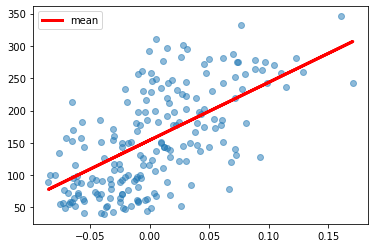

In [95]:
yhat_test = model(X_test)

plt.scatter(X_test, y_test, alpha=0.5);
plt.plot(X_test, yhat_test.mean(),'r', label='mean', linewidth=3);
plt.legend();

# Aleatoric Uncertainty

In [6]:
# create model to learn the 2 parameters of the normal distribution
# paramenters to learn: loc, mean, and scale, standard deviation. 
# because the standard deviation cannot be negative we use the softplus function
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])))
])


ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.9; Detected an installation of version 2.8.0. Please upgrade TensorFlow to proceed.

In [104]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

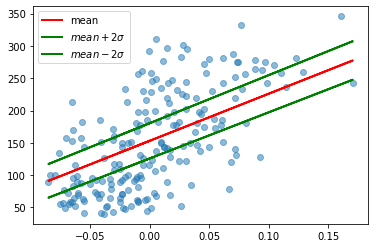

In [107]:
yhat_test = model(X_test)

plt.scatter(X_test, y_test, alpha=0.5);

m = yhat_test.mean()
s = yhat_test.stddev()

plt.plot(X_test, m, 'r', linewidth=2, label='mean');
plt.plot(X_test, m + 2 * s, 'g', linewidth=2, label=r'$mean + 2 \sigma$');
plt.plot(X_test, m - 2 * s, 'g', linewidth=2, label=r'$mean - 2 \sigma$');

plt.legend();

# Epistemic Uncertainty

In [108]:
# posterior
def posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
  
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                        scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1))
  ])

In [109]:
# prior
def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1))
  ])

In [110]:
# create model
# DenseVariational layer fits the weights posterior
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, 
                              posterior, 
                              prior, 
                              kl_weight=1/X.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])


In [111]:
# inference
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

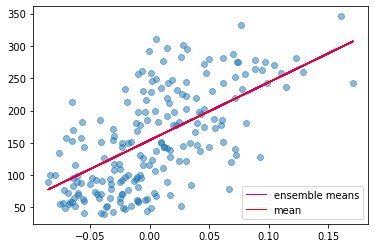

In [112]:
plt.scatter(X_test, y_test, alpha=0.5);
yhat_test_ = [model(X_test) for _ in range(200)]
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhat_test_):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
  
    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1);
    avgm += m

plt.plot(X_test, avgm/len(yhat_test_), 'r', label='mean', linewidth=1);

plt.legend();

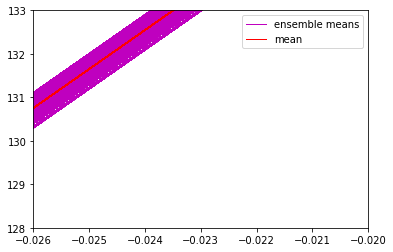

In [113]:
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhat_test_):
    m = np.squeeze(yhat.mean())
    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1)
    avgm += m

plt.plot(X_test, avgm/len(yhat_test_), 'r', label='mean', linewidth=1);

plt.ylim(128,133);
plt.xlim(-0.026, -0.02);

plt.legend();

# Aleatoric & Epistemic Uncertainty

In [249]:
# create model that fits the weights posterior and the model posterior
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(2, 
                              posterior, 
                              prior, 
                              kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))
])


In [250]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train, y_train, epochs=2000, verbose=False);

In [251]:
X_test.size

200

In [252]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 49.5165


49.5164794921875

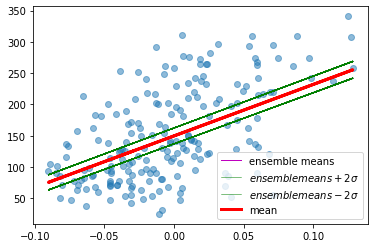

In [253]:
plt.scatter(X_test, y_test, alpha=0.5);

yhats = [model(X_test) for _ in range(200)]
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())

    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(X_test, m + 2 * s, 'g', linewidth=0.5, label='$ensemble means + 2 \sigma$' if i == 0 else None);
    plt.plot(X_test, m - 2 * s, 'g', linewidth=0.5, label='$ensemble means - 2 \sigma$' if i == 0 else None);
    avgm += m

plt.plot(X_test, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();


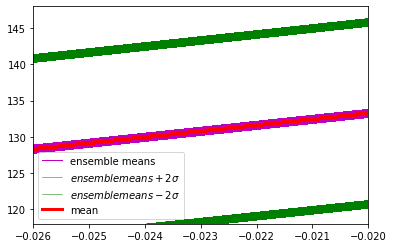

In [254]:
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())

    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(X_test, m + 2 * s, 'g', linewidth=0.5, label='$ensemble means + 2 \sigma$' if i == 0 else None);
    plt.plot(X_test, m - 2 * s, 'g', linewidth=0.5, label='$ensemble means - 2 \sigma$' if i == 0 else None);
    avgm += m

plt.ylim(118,148);
plt.xlim(-0.026, -0.02);
plt.plot(X_test, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();

In [255]:
yhat_test = model(X_test)
print("Std Epistemic: {}".format(np.squeeze(yhat_test.stddev()).std(ddof=1)))

Std Epistemic: 0.1404375582933426


In [256]:
print("Std Aleatoric: {}".format(np.squeeze(yhat_test.mean()).std(ddof=1)))

Std Aleatoric: 37.84490966796875


## Reduced training set sizes 1/2

In [257]:
n_data = X_train.size
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train[:n_data//2], y_train[:n_data//2], epochs=2000, verbose=False);

In [258]:
X_train[:n_data//2].size

121

In [259]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 4ms/step - loss: 15.7827


15.78270149230957

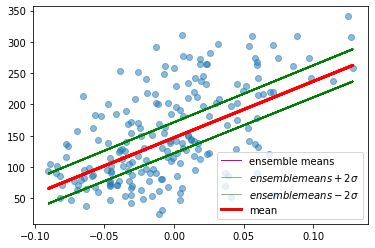

In [260]:
plt.scatter(X_test, y_test, alpha=0.5);

yhats = [model(X_test) for _ in range(200)]
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())

    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(X_test, m + 2 * s, 'g', linewidth=0.5, label='$ensemble means + 2 \sigma$' if i == 0 else None);
    plt.plot(X_test, m - 2 * s, 'g', linewidth=0.5, label='$ensemble means - 2 \sigma$' if i == 0 else None);
    avgm += m

plt.plot(X_test, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();

In [261]:
yhat_test = model(X_test)
print("Std Epistemic: {}".format(np.squeeze(yhat_test.stddev()).std(ddof=1)))

Std Epistemic: 0.1983528584241867


In [262]:
print("Std Aleatoric: {}".format(np.squeeze(yhat_test.mean()).std(ddof=1)))

Std Aleatoric: 41.36091613769531


## Reduced training set sizes 1/4

In [269]:
n_data = X_train.size
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=negloglik)
model.fit(X_train[:n_data//4], y_train[:n_data//4], epochs=2000, verbose=False);

In [270]:
X_train[:n_data//4].size

60

In [271]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 5ms/step - loss: 9.6619


9.661864280700684

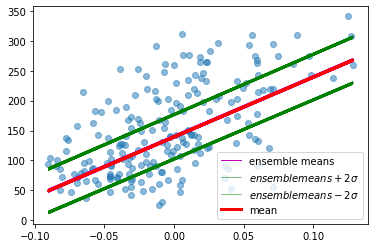

In [272]:
plt.scatter(X_test, y_test, alpha=0.5);

yhats = [model(X_test) for _ in range(200)]
avgm = np.zeros_like(X_test[..., 0])

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())

    plt.plot(X_test, m, 'm', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(X_test, m + 2 * s, 'g', linewidth=0.5, label='$ensemble means + 2 \sigma$' if i == 0 else None);
    plt.plot(X_test, m - 2 * s, 'g', linewidth=0.5, label='$ensemble means - 2 \sigma$' if i == 0 else None);
    avgm += m

plt.plot(X_test, avgm/len(yhats), 'r', label='mean', linewidth=3);
plt.legend();

In [273]:
yhat_test = model(X_test)
print("Std Epistemic: {}".format(np.squeeze(yhat_test.stddev()).std(ddof=1)))

Std Epistemic: 0.2141447365283966


In [274]:
print("Std Aleatoric: {}".format(np.squeeze(yhat_test.mean()).std(ddof=1)))

Std Aleatoric: 45.90785217285156


# Nonlinear Probabilistic Regression

In [275]:
X_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(X_train, 3) + 0.1 * (2 + X_train) * np.random.randn(1000)[:, np.newaxis]

In [276]:
# create model that fits the weights posterior and the model posterior 
# with activation layer sigmoid to add not linearity
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(units=2,
                              make_posterior_fn=posterior, 
                              make_prior_fn=prior, 
                              kl_weight=1/X.shape[0],
                              activation='sigmoid'),


  tfp.layers.DenseVariational(units=2,
                              make_posterior_fn=posterior, 
                              make_prior_fn=prior, 
                              kl_weight=1/X.shape[0],
                              ),
    
   tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),

])


In [277]:
model.compile(loss=negloglik, optimizer=tf.optimizers.Adam(learning_rate=0.1))

In [283]:
model.fit(X_train, y_train, epochs=2000, verbose=False)
model.evaluate(X_train, y_train)

32/32 [==============================] - 0s 5ms/step - loss: -0.0797


-0.07965496182441711

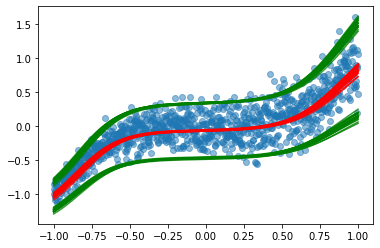

In [284]:
plt.scatter(X_train, y_train, alpha=0.5)

for i in range(20):
    y_model = model(X_train)
    y_hat = y_model.mean()

    plt.plot(X_train, y_hat, color='red', alpha=0.8, 
             label='model $\mu$' if i == 0 else None)
    plt.plot(X_train, y_hat - 2 * y_model.stddev(), color='green', 
             alpha=0.8, label='model $\mu \pm 2 \sigma$' if i == 0 else None)
    plt.plot(X_train, y_hat + 2 * y_model.stddev(), color='green', alpha=0.8)

plt.show()

In [285]:
yhat_test = model(X_train)
print("Std Epistemic: {}".format(np.squeeze(yhat_test.stddev()).std(ddof=1)))

Std Epistemic: 0.04790053144097328


In [286]:
print("Std Aleatoric: {}".format(np.squeeze(yhat_test.mean()).std(ddof=1)))

Std Aleatoric: 0.3806305527687073


## Reduced training set sizes 1/2

In [300]:
select_ =np.random.choice(X_train.size-1, X_train.size//2, replace=False)

In [301]:
model.fit(X_train[select_], y_train[select_], epochs=2000, verbose=False)
model.evaluate(X_train, y_train)

32/32 [==============================] - 0s 2ms/step - loss: -0.1793


-0.1793038249015808

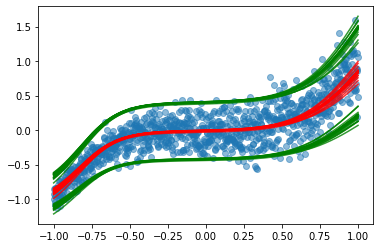

In [302]:
plt.scatter(X_train, y_train, alpha=0.5)

for i in range(20):
    y_model = model(X_train)
    y_hat = y_model.mean()

    plt.plot(X_train, y_hat, color='red', alpha=0.8, 
             label='model $\mu$' if i == 0 else None)
    plt.plot(X_train, y_hat - 2 * y_model.stddev(), color='green', 
             alpha=0.8, label='model $\mu \pm 2 \sigma$' if i == 0 else None)
    plt.plot(X_train, y_hat + 2 * y_model.stddev(), color='green', alpha=0.8)

plt.show()

In [303]:
yhat_test = model(X_train)
print("Std Epistemic: {}".format(np.squeeze(yhat_test.stddev()).std(ddof=1)))

Std Epistemic: 0.040472641587257385


In [304]:
print("Std Aleatoric: {}".format(np.squeeze(yhat_test.mean()).std(ddof=1)))

Std Aleatoric: 0.3177242577075958


## Reduced training set sizes 1/4

In [305]:
select_ =np.random.choice(X_train.size-1, X_train.size//4, replace=False)

In [306]:
model.fit(X_train[select_], y_train[select_], epochs=2000, verbose=False)
model.evaluate(X_train, y_train)

32/32 [==============================] - 0s 4ms/step - loss: -0.1685


-0.16853544116020203

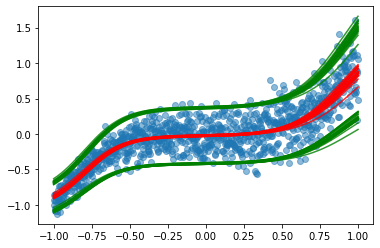

In [307]:
plt.scatter(X_train, y_train, alpha=0.5)

for i in range(20):
    y_model = model(X_train)
    y_hat = y_model.mean()

    plt.plot(X_train, y_hat, color='red', alpha=0.8, 
             label='model $\mu$' if i == 0 else None)
    plt.plot(X_train, y_hat - 2 * y_model.stddev(), color='green', 
             alpha=0.8, label='model $\mu \pm 2 \sigma$' if i == 0 else None)
    plt.plot(X_train, y_hat + 2 * y_model.stddev(), color='green', alpha=0.8)

plt.show()

In [308]:
yhat_test = model(X_train)
print("Std Epistemic: {}".format(np.squeeze(yhat_test.stddev()).std(ddof=1)))

Std Epistemic: 0.042595911771059036


In [309]:
print("Std Aleatoric: {}".format(np.squeeze(yhat_test.mean()).std(ddof=1)))

Std Aleatoric: 0.35786622762680054
